In [192]:
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio

In [186]:
# CONSTANTS

# Base Coordinate System EPSG code 
BASE_CRS = 4326 
# Location center [minx, miny, maxx, maxy]
# LOC = [-19.3758794, 47.33124417, -19.07561176, 47.63146114]
LOC = [-19.2758794, 47.43124417, -19.17561176, 47.53146114]
# Raster directory
DIR = 'layers/'

In [189]:
tifs = []
shps = []

# Iterate through directory
for subdir, dirs, files in os.walk(DIR):
    for f in files:
        path = subdir + os.sep + f
        if path.endswith(".tif"):
            tifs.append(path)
        elif path.endswith(".shp"):
            shps.append(path)
            
for ds_path in tifs:
    # Select raster image 
    print("\nOpening " + ds_path)
    ds = gdal.Open(ds_path)

    # Get the number of layers
    print("Number of Layers: " + str(ds.RasterCount))
    # print(dir(ds.GetRasterBand(0).GetStatistics(True, True))

    # Get source coordinate reference type 
    projection = int(osr.SpatialReference(wkt=ds.GetProjection()).GetAttrValue('AUTHORITY',1))
    print("EPSG: " + str(projection))
    source = osr.SpatialReference()
    source.ImportFromEPSG(projection)

    # Set target coordinate reference 
    target = osr.SpatialReference()
    target.ImportFromEPSG(BASE_CRS)

    # Create point transformation
    transform = osr.CoordinateTransformation(source, target)

    # Get raster coordinates (rc) in source reference 
    rc = getRasterCoords(ds)
    print(rc)
    
    # Convert raster coordinates to target reference
    rc_conv = np.array([])
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(rc[0], rc[1])
    point.Transform(transform)
    rc_conv = np.concatenate((rc_conv, [point.GetX(), point.GetY()]))
    point.AddPoint(rc[2], rc[3])
    point.Transform(transform)
    rc_conv = np.concatenate((rc_conv, [point.GetX(), point.GetY()]))
    print("Raster coordinates in target reference: " + str(rc_conv))
    
    # Check if raster contains the desired location
    if rasterContainsLoc(rc_conv):
        band = ds.GetRasterBand(1)
        bandData = band.ReadAsArray()
        # Raster Shape
        print("Raster Shape: " + str(bandData.shape))

    else:
        print("Raster does not contain location: " + str(LOC))
        





Opening layers//img.tif
Number of Layers: 20
EPSG: 3857
[5268890.0, -2199240.0, 5302310.0, -2163840.0]
Raster coordinates in target reference: [-19.3758794   47.33124417 -19.07561176  47.63146114]
1114
Raster Shape: (1180, 1114)

Opening layers//basic.tif
Number of Layers: 28
EPSG: 4326
[-180.0, -90.56137210802382, 180.22442893192812, 90.0]
Raster coordinates in target reference: [-180.          -90.56137211  180.22442893   90.        ]
401
Raster Shape: (201, 401)


In [127]:
def getRasterCoords(ds):
    
    gt = ds.GetGeoTransform()
    w = ds.RasterXSize
    h = ds.RasterYSize
    
    minx = gt[0]
    maxy = gt[3] 
    miny = gt[3] + w*gt[4] + h*gt[5] 
    maxx = gt[0] + w*gt[1] + h*gt[2]
    
    return[minx, miny, maxx, maxy]

In [174]:
def rasterContainsLoc(rc):
    if LOC[0] >= rc[0] and LOC[3] <= rc[3] and LOC[1] >= rc[1] and LOC[3] <= rc[3]:
        return True
    else:
        return False

In [66]:
gdal.UseExceptions()


src = osr.SpatialReference()
src.SetWellKnownGeogCS("WGS84")

transform = ds.GetGeoTransform()

dataset = gdal.Open("layers/basic.tif");
projection = dataset.GetProjection();
dst = osr.SpatialReference(projection);

ct = osr.CoordinateTransformation(src, dst);

xy = ct.TransformPoint(5298307.7,-2165880.1);

x = (int)(((xy[0] - transform[0]) / transform[1]));
y = (int)(((xy[1] - transform[3]) / transform[5]));

print(x, y)
    
#     width = ds.RasterXSize
#     height = ds.RasterYSize
#     gt = ds.GetGeoTransform()
#     minx = gt[0]
#     miny = gt[3] + width*gt[4] + height*gt[5] 
#     maxx = gt[0] + width*gt[1] + height*gt[2]
#     maxy = gt[3] 
    
#     print(minx, miny, maxx, maxy)

    
#     geotiff = gdal.GetDriverByName("GTiff")
    
#     # Identify raster origin and pixel size
#     gt_transform = ds.GetGeoTransform()
#     x_org = gt_transform[0]
#     y_org = gt_transform[3]
#     pixel_w = gt_transform[1]
#     pixel_h = -gt_transform[5]

#     # Number of bands
#     print("Number of Bands: " + str(ds.RasterCount))

#     # Select band
#     band = ds.GetRasterBand(15)
#     bandData = band.ReadAsArray()

#     # Raster Shape
#     print("Raster Shape: " + str(bandData.shape))

5898249 2411146


In [100]:
from osgeo import osr, ogr, gdal


def world_to_pixel(geo_matrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

# Extract target reference from the tiff file
ds = gdal.Open('layers/img.tif')

proj = osr.SpatialReference(wkt=ds.GetProjection())
print(proj.GetAttrValue('AUTHORITY',1))

# target = osr.SpatialReference(wkt=ds.GetProjection())
target = osr.SpatialReference()
target.ImportFromEPSG(4326)

print(target)
source = osr.SpatialReference()
source.ImportFromEPSG( 3857)

transform = osr.CoordinateTransformation(source, target)

point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(4865942.28, 2226389.82)
point.Transform(transform)

x, y = world_to_pixel(ds.GetGeoTransform(), point.GetX(), point.GetY())
print(x, y)

3857
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
-175629 -72129


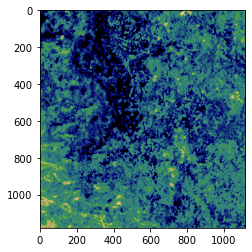

In [78]:
# Visualzie data
plt.imshow(ds.GetRasterBand(15).ReadAsArray(), cmap='gist_earth')
plt.show()

In [14]:
# Converting coordinates 
# https://gis.stackexchange.com/questions/29632/getting-elevation-at-lat-long-from-raster-using-python

def pixelToMap(gt, pos):
    return (gt[0] + pos[0] * gt[1] + pos[1] * gt[2],
            gt[3] + pos[0] * gt[4] + pos[1] * gt[5])

def mapToPixel(gt, pos):
    s = gt[0] * gt[4] - gt[3] * gt[1]
    x = (gt[4] * pos[0] - gt[1] * pos[1] + gt[1] * gt[5] - gt[4] * gt[2]) / s
    y = (-gt[3] * pos[0] + gt[0] * pos[1] + gt[3] * gt[2] - gt[0] * gt[5]) / s
    return (x, y)
